# Blackblaze dataset preliminary results

In [18]:
%matplotlib inline
from collections import OrderedDict
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index, k_fold_cross_validation
import patsy as pt
from sklearn.model_selection import train_test_split

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 10, 6

np.random.seed(0)

In [29]:
# Loading the data 
df = pd.read_csv('../data/drive_survival_prepared_2.csv'
                 ,index_col='diskid', parse_dates=['mindate','maxdate'])
df.head()

,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym
diskid,,,,,,,,,,,
13H2B97AS,DT01ACA300,2015-04-21,2017-07-25,911,10153,29961,0,TOSHIBA,3.0TB,201504,201707
13H32WEAS,DT01ACA300,2015-01-01,2017-08-03,1030,14765,37431,0,TOSHIBA,3.0TB,201501,201708
13H6A21GS,DT01ACA300,2015-01-01,2017-08-18,1045,14133,37155,0,TOSHIBA,3.0TB,201501,201708
13H7X2HAS,DT01ACA300,2015-12-17,2017-04-26,583,9775,21667,0,TOSHIBA,3.0TB,201512,201704
13H80PNGS,DT01ACA300,2015-01-01,2015-08-13,225,11765,17138,0,TOSHIBA,3.0TB,201501,201508


In [21]:
# Choose the features from the data to take into account 
features = ['manufacturer','capacity','maxhours','failed']
cox_data = df[features]
# Transform the categorical features into boolean encoding
cox_data = pd.get_dummies(cox_data, columns=['manufacturer', 'capacity'])

print(cox_data.shape)
cox_data.T.head()

(105364, 10)


diskid,13H2B97AS,13H32WEAS,13H6A21GS,13H7X2HAS,13H80PNGS,13H85BMGS,13H87YWAS,13H89KSGS,13H89U2GS,13H8AB0GS,...,ZDH0ZNA3,ZDH165EX,ZDH185C0,ZDH18D4D,ZDH1BGF0,ZDH1DSW3,ZDH1DTEP,ZGY001Q8,ZGY07FYA,ZGY0CDT1
maxhours,29961,37431,37155,21667,17138,34400,34426,36786,27879,29774,...,541,180,539,707,584,603,705,366,708,227
failed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
manufacturer_HGST,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
manufacturer_SEAGATE,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
manufacturer_TOSHIBA,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Creating a stratified validation set representing 20% of the data
# cox_tr is the training set and cox_va the validation set
cox_tr, cox_va = train_test_split(cox_data, test_size=0.2, random_state=15125)

In [30]:
cox = CoxPHFitter()
# You might need to adjust the step_size
cox.fit(cox_data, duration_col='maxhours', event_col='failed', show_progress=True, step_size=0.0008)

Iteration 1: norm_delta = 0.00187, step_size = 0.00080, ll = -35672.74788, seconds_since_start = 1.6
Iteration 2: norm_delta = 0.00119, step_size = 0.00080, ll = -35671.49844, seconds_since_start = 3.2
Iteration 3: norm_delta = 0.00049, step_size = 0.00080, ll = -35670.25090, seconds_since_start = 4.7
Iteration 4: norm_delta = 0.00078, step_size = 0.00096, ll = -35669.00528, seconds_since_start = 6.3
Iteration 5: norm_delta = 0.00054, step_size = 0.00094, ll = -35667.51292, seconds_since_start = 7.8
Iteration 6: norm_delta = 0.00070, step_size = 0.00092, ll = -35666.05308, seconds_since_start = 9.4
Iteration 7: norm_delta = 0.00070, step_size = 0.00090, ll = -35664.62499, seconds_since_start = 11.0
Iteration 8: norm_delta = 0.00165, step_size = 0.00089, ll = -35663.22791, seconds_since_start = 12.5
Iteration 9: norm_delta = 0.00089, step_size = 0.00087, ll = -35661.86112, seconds_since_start = 14.1
Iteration 10: norm_delta = 0.00050, step_size = 0.00085, ll = -35660.52391, seconds_sinc

<lifelines.CoxPHFitter: fitted with 105364 observations, 102054 censored>

In [31]:
cox.print_summary()

n=105364, number of events=3310

                        coef  exp(coef)    se(coef)       z      p   lower 0.95  upper 0.95   
manufacturer_HGST    -0.0384     0.9624 117733.1441 -0.0000 1.0000 -230752.7606 230752.6839   
manufacturer_SEAGATE  0.0164     1.0165 117730.9270  0.0000 1.0000 -230748.3604 230748.3931   
manufacturer_TOSHIBA -0.0206     0.9796 117726.6956 -0.0000 1.0000 -230740.1040 230740.0628   
manufacturer_WDC      0.0321     1.0326 117732.3400  0.0000 1.0000 -230751.1143 230751.1784   
capacity_12.0TB      -0.0036     0.9964 246769.5965 -0.0000 1.0000 -483659.5252 483659.5180   
capacity_3.0TB        0.0106     1.0107 246769.5965  0.0000 1.0000 -483659.5110 483659.5322   
capacity_4.0TB        0.0144     1.0145 246769.5965  0.0000 1.0000 -483659.5072 483659.5360   
capacity_8.0TB       -0.0108     0.9892 246769.5965 -0.0000 1.0000 -483659.5324 483659.5108   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.656
Likelihood ratio test =

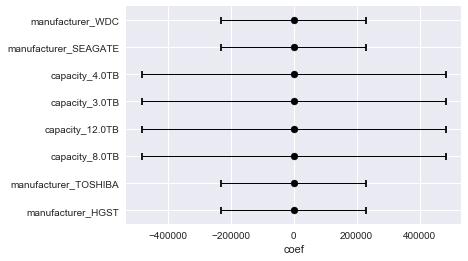

In [32]:
cox.plot()

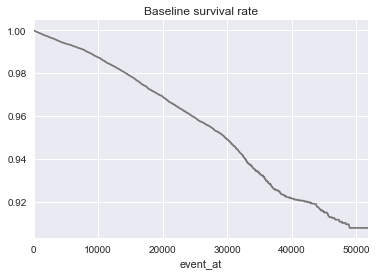

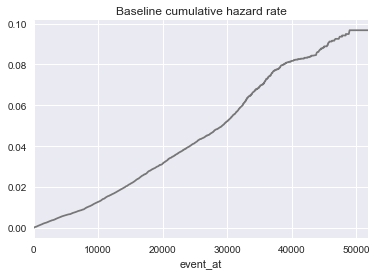

In [33]:
%matplotlib inline
cox.baseline_survival_.plot(legend=False, title='Baseline survival rate')
cox.baseline_cumulative_hazard_.plot(legend=False, title='Baseline cumulative hazard rate')

In [34]:
cox.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
manufacturer_HGST,-0.038359,0.962367,117733.144096,-3.258159e-07,1.0,-230752.760574,230752.683855
manufacturer_SEAGATE,0.016367,1.016502,117730.926978,1.390192e-07,1.0,-230748.360377,230748.393110
manufacturer_TOSHIBA,-0.020626,0.979585,117726.695595,-1.752035e-07,1.0,-230740.104012,230740.062760
manufacturer_WDC,0.032061,1.032580,117732.340049,2.723191e-07,1.0,-230751.114251,230751.178372
capacity_12.0TB,-0.003640,0.996366,246769.596486,-1.475201e-08,1.0,-483659.525233,483659.517952
capacity_3.0TB,0.010643,1.010700,246769.596487,4.312810e-08,1.0,-483659.510951,483659.532236
capacity_4.0TB,0.014417,1.014521,246769.596486,5.842315e-08,1.0,-483659.507176,483659.536010
capacity_8.0TB,-0.010814,0.989244,246769.596486,-4.382272e-08,1.0,-483659.532407,483659.510779


In [36]:
hazard_tr, hazard_va = cox.predict_partial_hazard(cox_tr), cox.predict_partial_hazard(cox_va)
score_tr = concordance_index(cox_tr['maxhours'], -hazard_tr, cox_tr['failed'])
score_va = concordance_index(cox_va['maxhours'], -hazard_va, cox_va['failed'])
print(score_tr, score_va)

0.65600406113 0.657489446979
